# Titanic challenge with XGBoost - EDA

This notebook resolves Titanic challenge using XGBoost model. The target is to get familiar with AWS Sagemaker and one of the most popular model - eXtreme Gradient Boosting.
The original challenge is defined at https://www.kaggle.com/c/titanic/data

This notebook is divided into 3 parts:
- The first part is about analyzing and visualize data.
- The second part is about feature engineering.
- The last part is for training and prediction.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import io
import os
import time
from IPython.display import display
from time import strftime, gmtime

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec



## 1. First glance on the data

The dataset includes following attributes:
- Passenger ID
- Survived: categorical variable, 0 means No, 1 means Yes
- Pclass: categorical variable indicates the ticket class
- Name: text variable contains title and full name of the passenger
- Sex: categorical variable of two values, male or female
- Age: continuous variable indicates the age of passenger
- SipSp: number of siblings and spouses aboard the Titanic
- Parch: number of parents and children aboard the Titanic
- Ticket: text variable indicate ticket ID
- Fare: continuous variable indicates the ticket fare
- Cabin: categorical variable about passenger’s cabin
- Embarked: categorical variable indicates port of embarkation. C, Q and S corre-spond to Cherbourg, Queenstown, Southampton respectively.

First let's load the data.

In [2]:
train_data_file = './data/raw/train.csv'
test_data_file = './data/raw/test.csv'

try:
    train_df = pd.read_csv(train_data_file)
    test_df = pd.read_csv(test_data_file)
    print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Success: Data loaded into dataframe.


In [3]:
# First 5 records
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### Missing value

In [23]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We can see that there are missing values in attributes Embarked, Age and Cabin, especially in Cabin when there are only 204 filled records over the total of 891. However the chosen algorithm XGBoost is able to handle missing value then we will let it be and have a try.

### Exploratory data analysis

An exploratory data analysis is necessary to understand the data and the relation between variables to the target. I tried to figure out the relation between Survived and some features like gender, ticket fare, and ticket class.

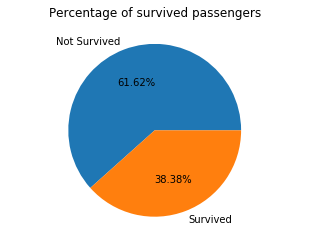

In [43]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
state = ['Not Survived', 'Survived']
ax.pie(train_df['Survived'].value_counts(), labels = state,autopct='%1.2f%%')
plt.title('Percentage of survived passengers')
plt.show()


#### Sex
Female has a higher posibility to be survived. It makes sense because in emergency cases children and women are prioritized.

In [44]:
train_df.groupby(['Survived','Sex'])['Sex'].count()
# train_df['Sex'].value_counts()

Survived  Sex   
0         female     81
          male      468
1         female    233
          male      109
Name: Sex, dtype: int64

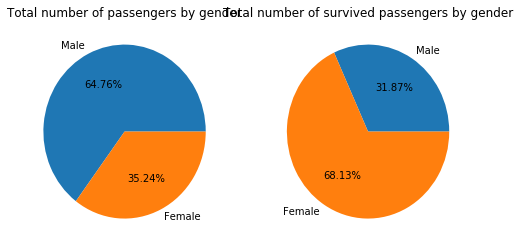

In [52]:
fig = plt.figure(figsize=(8,4))
gspec = gridspec.GridSpec(1, 2)

sex_total = fig.add_subplot(gspec[:1,0:1]) #pie chart of total male/female
sex_total.title.set_text('Total number of passengers by gender')
sex_survived = fig.add_subplot(gspec[:1, 1:2]) #pie chart of survived male/female
sex_survived.title.set_text('Total number of survived passengers by gender')

sex_total.pie(train_df['Sex'].value_counts(), labels = ['Male', 'Female'],autopct='%1.2f%%')
sex_survived.pie(train_df.groupby(['Survived','Sex'])['Sex'].count()[1][::-1], labels = ['Male', 'Female'],autopct='%1.2f%%')
plt.show()

#### Ticket fare:
People own higher ticket fare have more changes to be saved.

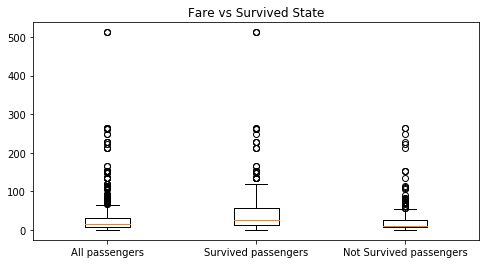

In [53]:
fig = plt.figure(figsize=(8,4))
plt.boxplot([train_df['Fare'], train_df.loc[train_df['Survived']==1,['Fare']]['Fare'],
             train_df.loc[train_df['Survived']==0,['Fare']]['Fare']], labels = ['All passengers', 'Survived passengers', 
                                                                                'Not Survived passengers'])
plt.title('Fare vs Survived State')
# plt.savefig('ti_fare')
plt.show()

#### Ticket class:

In [54]:
train_df['Pclass'].value_counts()
train_df.groupby(['Pclass', 'Survived'])['Survived'].count()
train_df.loc[train_df['Survived'] == 1,['Pclass']]['Pclass'].value_counts()

1    136
3    119
2     87
Name: Pclass, dtype: int64

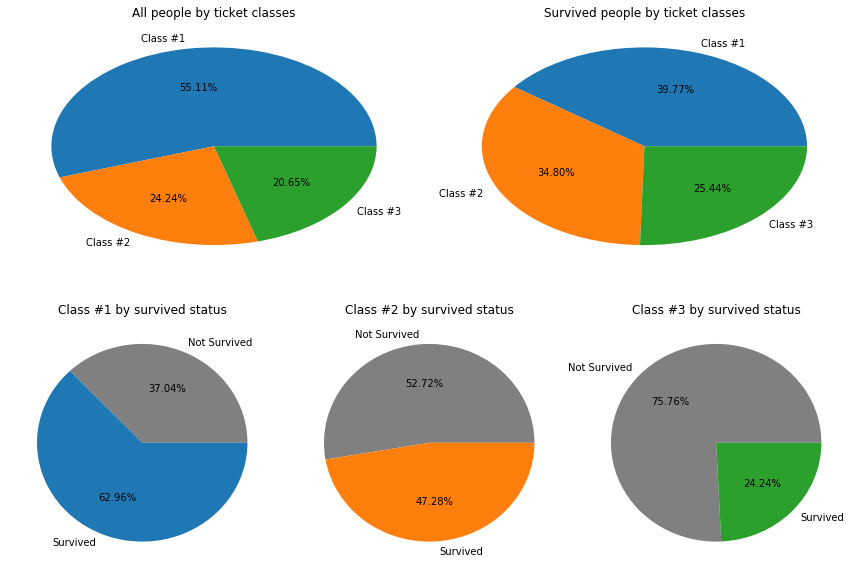

In [55]:
fig = plt.figure(figsize=(15,10))
gspec = gridspec.GridSpec(2, 6)

pclass = fig.add_subplot(gspec[:1,0:3])
pclass.title.set_text('All people by ticket classes')
pclass_survived = fig.add_subplot(gspec[:1,3:])
pclass_survived.title.set_text('Survived people by ticket classes')
pclass_1 = fig.add_subplot(gspec[1:,0:2])
pclass_1.title.set_text('Class #1 by survived status')
pclass_2 = fig.add_subplot(gspec[1:,2:4])
pclass_2.title.set_text('Class #2 by survived status')
pclass_3 = fig.add_subplot(gspec[1:,4:6])
pclass_3.title.set_text('Class #3 by survived status')

pclass.pie(train_df['Pclass'].value_counts(), labels = ['Class #1', 'Class #2', 'Class #3'],autopct='%1.2f%%')
pclass_survived.pie(train_df.loc[train_df['Survived'] == 1,['Pclass']]['Pclass'].value_counts(), labels = ['Class #1', 'Class #2', 'Class #3'],autopct='%1.2f%%')
pclass_1.pie(train_df.groupby(['Pclass', 'Survived'])['Survived'].count()[1], 
             colors=['gray','#1f77b4'],
             labels = ['Not Survived', 'Survived'],autopct='%1.2f%%')
pclass_2.pie(train_df.groupby(['Pclass', 'Survived'])['Survived'].count()[2], 
             colors=['gray','#ff7f0e'],
             labels = ['Not Survived', 'Survived'],autopct='%1.2f%%')
pclass_3.pie(train_df.groupby(['Pclass', 'Survived'])['Survived'].count()[3],
             colors=['gray','#2ca02c'],
             labels = ['Not Survived', 'Survived'],autopct='%1.2f%%')
# plt.savefig('ti_pclass')
plt.show()

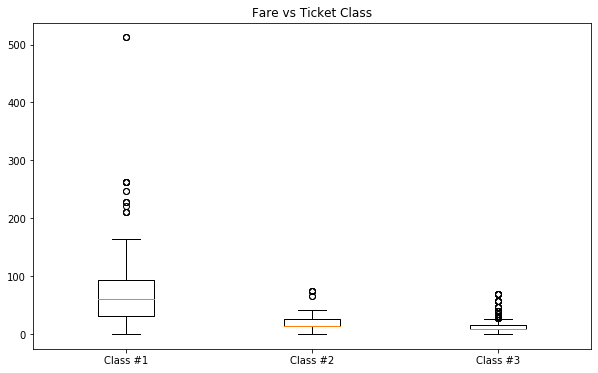

In [15]:
fig = plt.figure(figsize=(10,6))
plt.boxplot([train_df.loc[train_df['Pclass']==1,['Fare']]['Fare'], train_df.loc[train_df['Pclass']==2,['Fare']]['Fare'],
             train_df.loc[train_df['Pclass']==3,['Fare']]['Fare']], labels = ['Class #1', 'Class #2', 
                                                                                'Class #3'])
plt.title('Fare vs Ticket Class')
# plt.savefig('ti_fare_ticket')
plt.show()

#### Age:

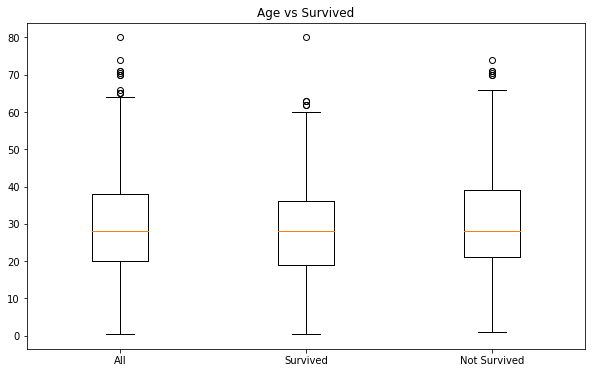

In [34]:
fig = plt.figure(figsize=(10,6))
plt.boxplot([train_df.loc[train_df['Age'].notna() == True, ['Age']]['Age'], 
             train_df.loc[(train_df['Survived']==1) & (train_df['Age'].notna() == True),['Age']]['Age'], 
            train_df.loc[(train_df['Survived']==0) & (train_df['Age'].notna() == True),['Age']]['Age']],
            labels = ['All', 'Survived', 'Not Survived'])
plt.title('Age vs Survived')
# plt.savefig('ti_fare_ticket')
plt.show()

#### SibSp and Parch
- Data is incompleted: there is information of only one person in a family of 6.

In [16]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

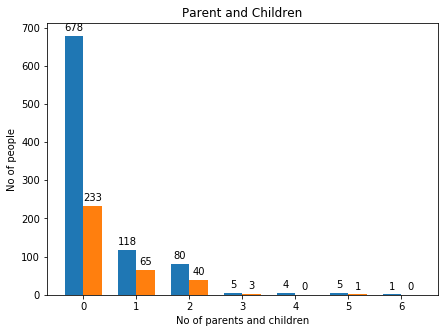

In [77]:
fig = plt.figure(figsize=(7,5))
plt.title('Parent and Children')
parch = train_df.groupby(['Parch'])['PassengerId'].count()
parch_survived = train_df.groupby(['Parch'])['Survived'].sum()

ax  = plt.gca()
# ax.bar(parch.index.values, parch)
ax.set_ylabel('No of people')
ax.set_xlabel('No of parents and children')

items = parch.index.values
width = 0.35
rects1 = ax.bar(items - width/2, parch, width, label='All')
rects2 = ax.bar(items + width/2, parch_survived, width, label='Survived')
        
# # Make some labels.
# labels_parch = parch.values
# rects = ax.patches
# for rect, label in zip(rects, labels_parch):
#     height = rect.get_height()
#     ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
#             ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

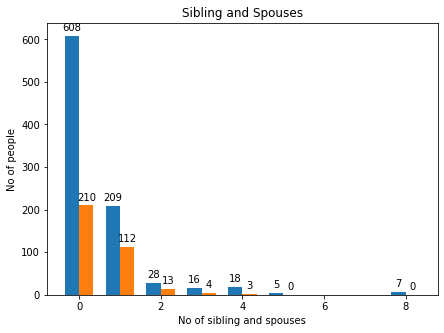

In [78]:
fig = plt.figure(figsize=(7,5))
plt.title('Sibling and Spouses')
sibsp = train_df.groupby(['SibSp'])['PassengerId'].count()
sibsp_survived = train_df.groupby(['SibSp'])['Survived'].sum()

ax  = plt.gca()
# ax.bar(parch.index.values, parch)
ax.set_ylabel('No of people')
ax.set_xlabel('No of sibling and spouses')

items = sibsp.index.values
width = 0.35
rects1 = ax.bar(items - width/2, sibsp, width, label='All')
rects2 = ax.bar(items + width/2, sibsp_survived, width, label='Survived')

autolabel(rects1)
autolabel(rects2)

plt.show()

In [12]:
train_df['Alone'] = (train_df['SibSp'] + train_df['Parch'] == 0)

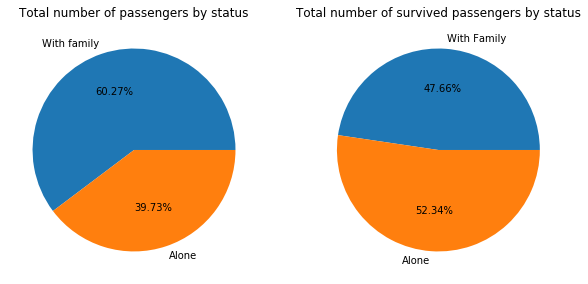

In [18]:
# fig = plt.figure(figsize=(7,5))
# plt.title('Alone vs With Family')
# alone = train_df.groupby(['Alone'])['PassengerId'].count()
# alone_survived = train_df.groupby(['Alone'])['Survived'].sum()

# ax  = plt.gca()
# # ax.bar(parch.index.values, parch)
# ax.set_ylabel('No of people')

# items = alone.index.values
# width = 0.35
# rects1 = ax.bar(items - width/2, alone, width, label='All')
# rects2 = ax.bar(items + width/2, alone_survived, width, label='Survived')

# autolabel(rects1)
# autolabel(rects2)

# plt.show()

fig = plt.figure(figsize=(10,7))
gspec = gridspec.GridSpec(1, 2)

alone_total = fig.add_subplot(gspec[:1,0:1]) 
alone_total.title.set_text('Total number of passengers by status')
alone_survived = fig.add_subplot(gspec[:1, 1:2]) 
alone_survived.title.set_text('Total number of survived passengers by status')

alone_total.pie(train_df['Alone'].value_counts(), labels = ['With family', 'Alone'],autopct='%1.2f%%')
alone_survived.pie(train_df.groupby(['Survived','Alone'])['Alone'].count()[1][::-1], labels = ['With Family', 'Alone'],autopct='%1.2f%%')
plt.show()

In [20]:
train_df.drop(['Alone'], axis=1, inplace=True)